### Загрузка необходимых модулей

In [1]:
from PIL import Image, ImageEnhance, ImageFilter
import numpy as np
from skimage import transform, filters
import os

### Открытие изображения

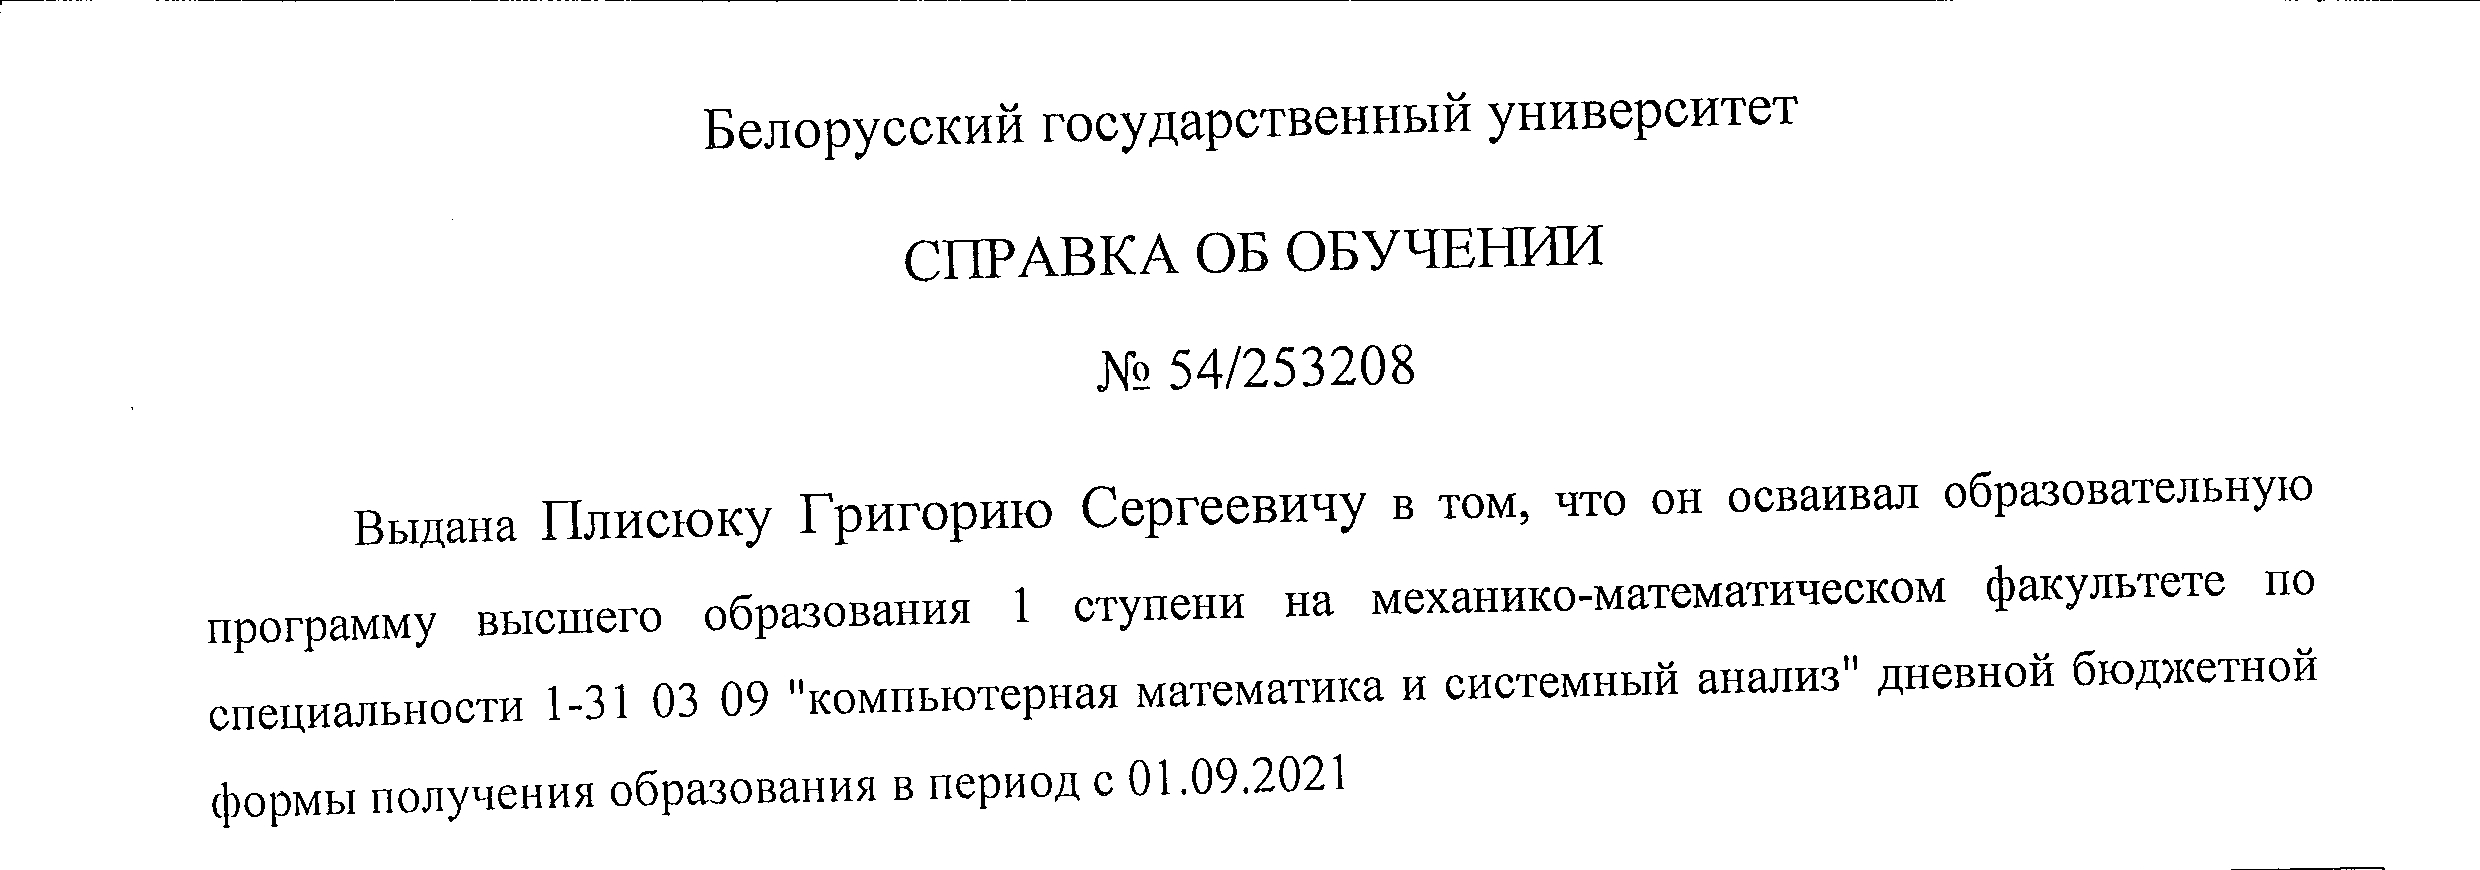

In [2]:
# открытие изображения средствами PIL
filename = 'scan_cut.png'

#filename = 'photo_2_cut.jpg'

#os.chdir('samples')
#filename = '3.jpg'

image = Image.open(filename)
image

### Удаление шума с изображения

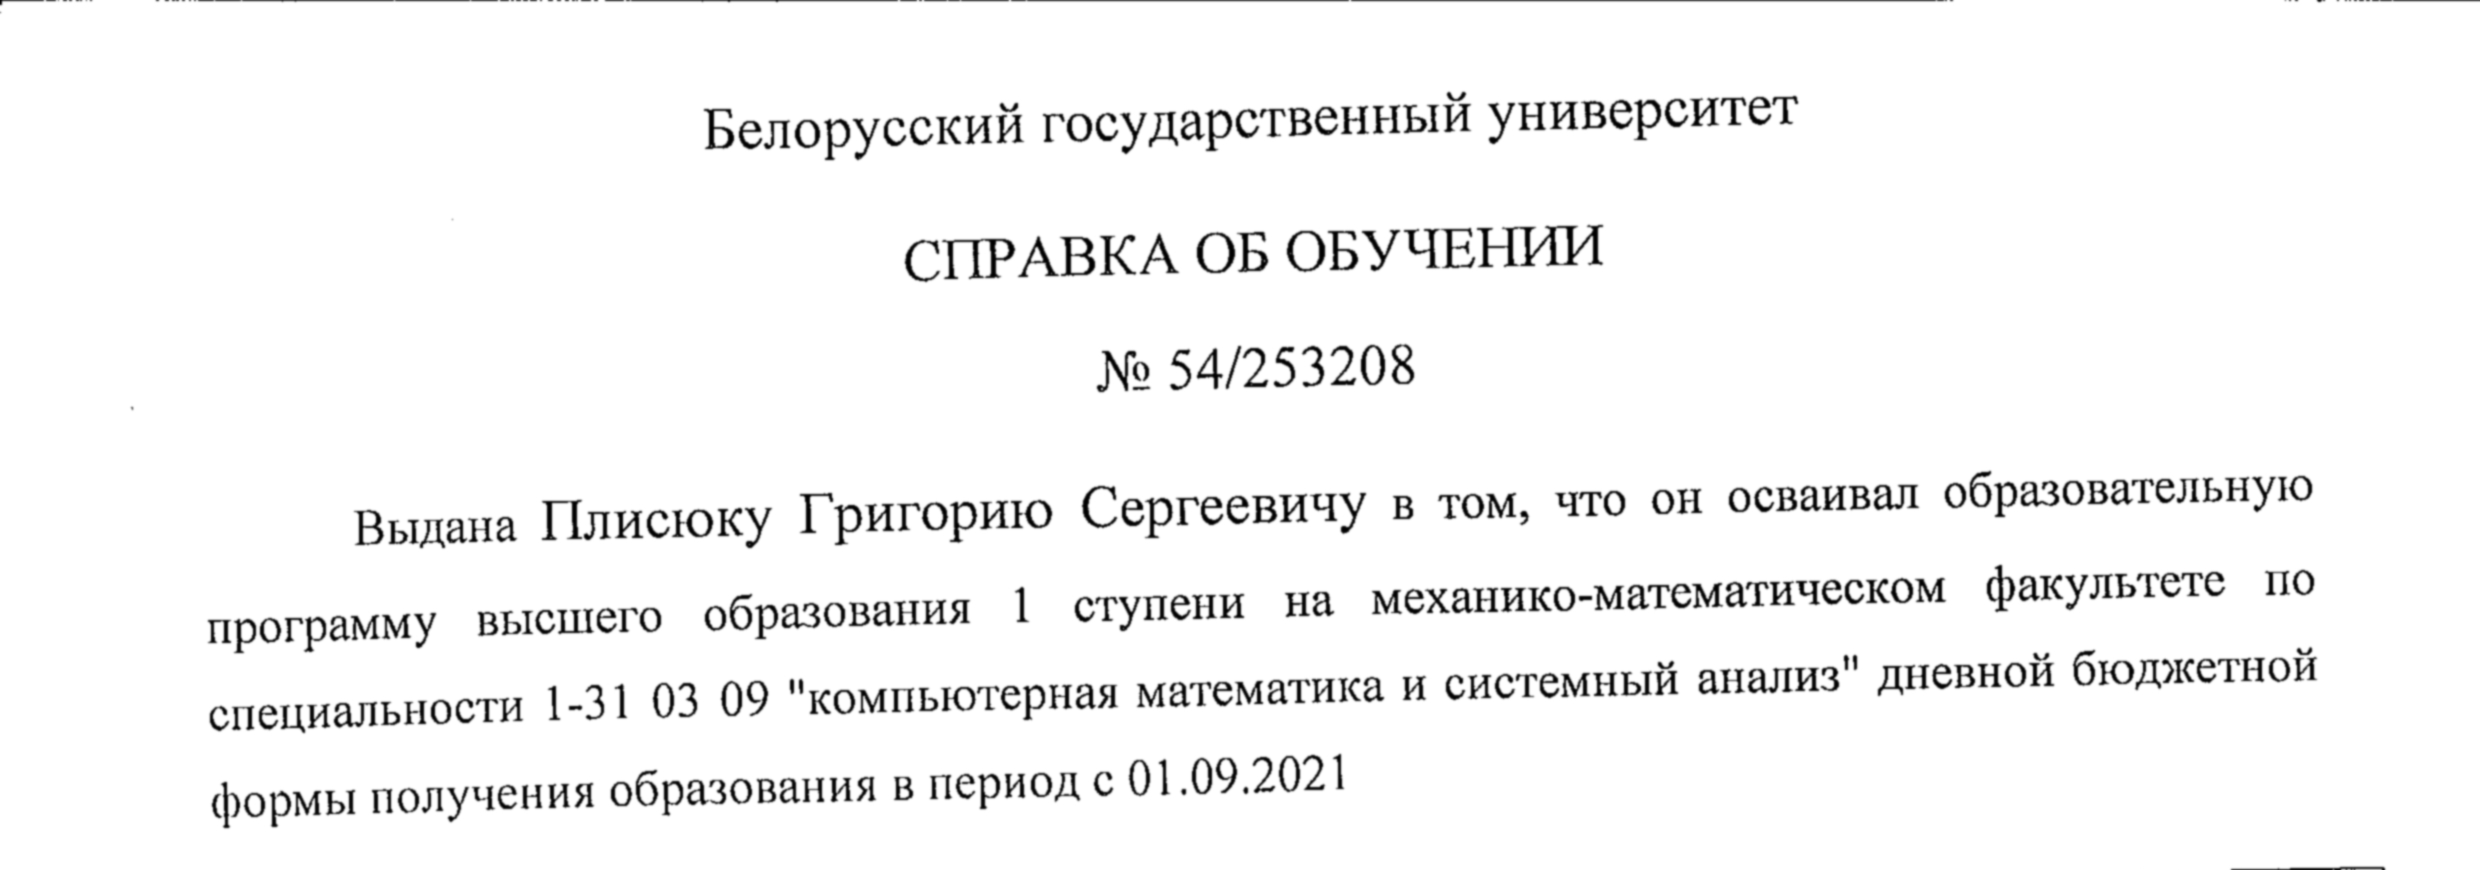

In [3]:
# размытие изображения с помощью ядра Гаусса 3x3 (сигма = 0.3*((размер-1)*0.5 - 1) + 0.8) средствами PIL
gauss_image = image.filter(ImageFilter.GaussianBlur(1))
gauss_image

### Предварительная обработка

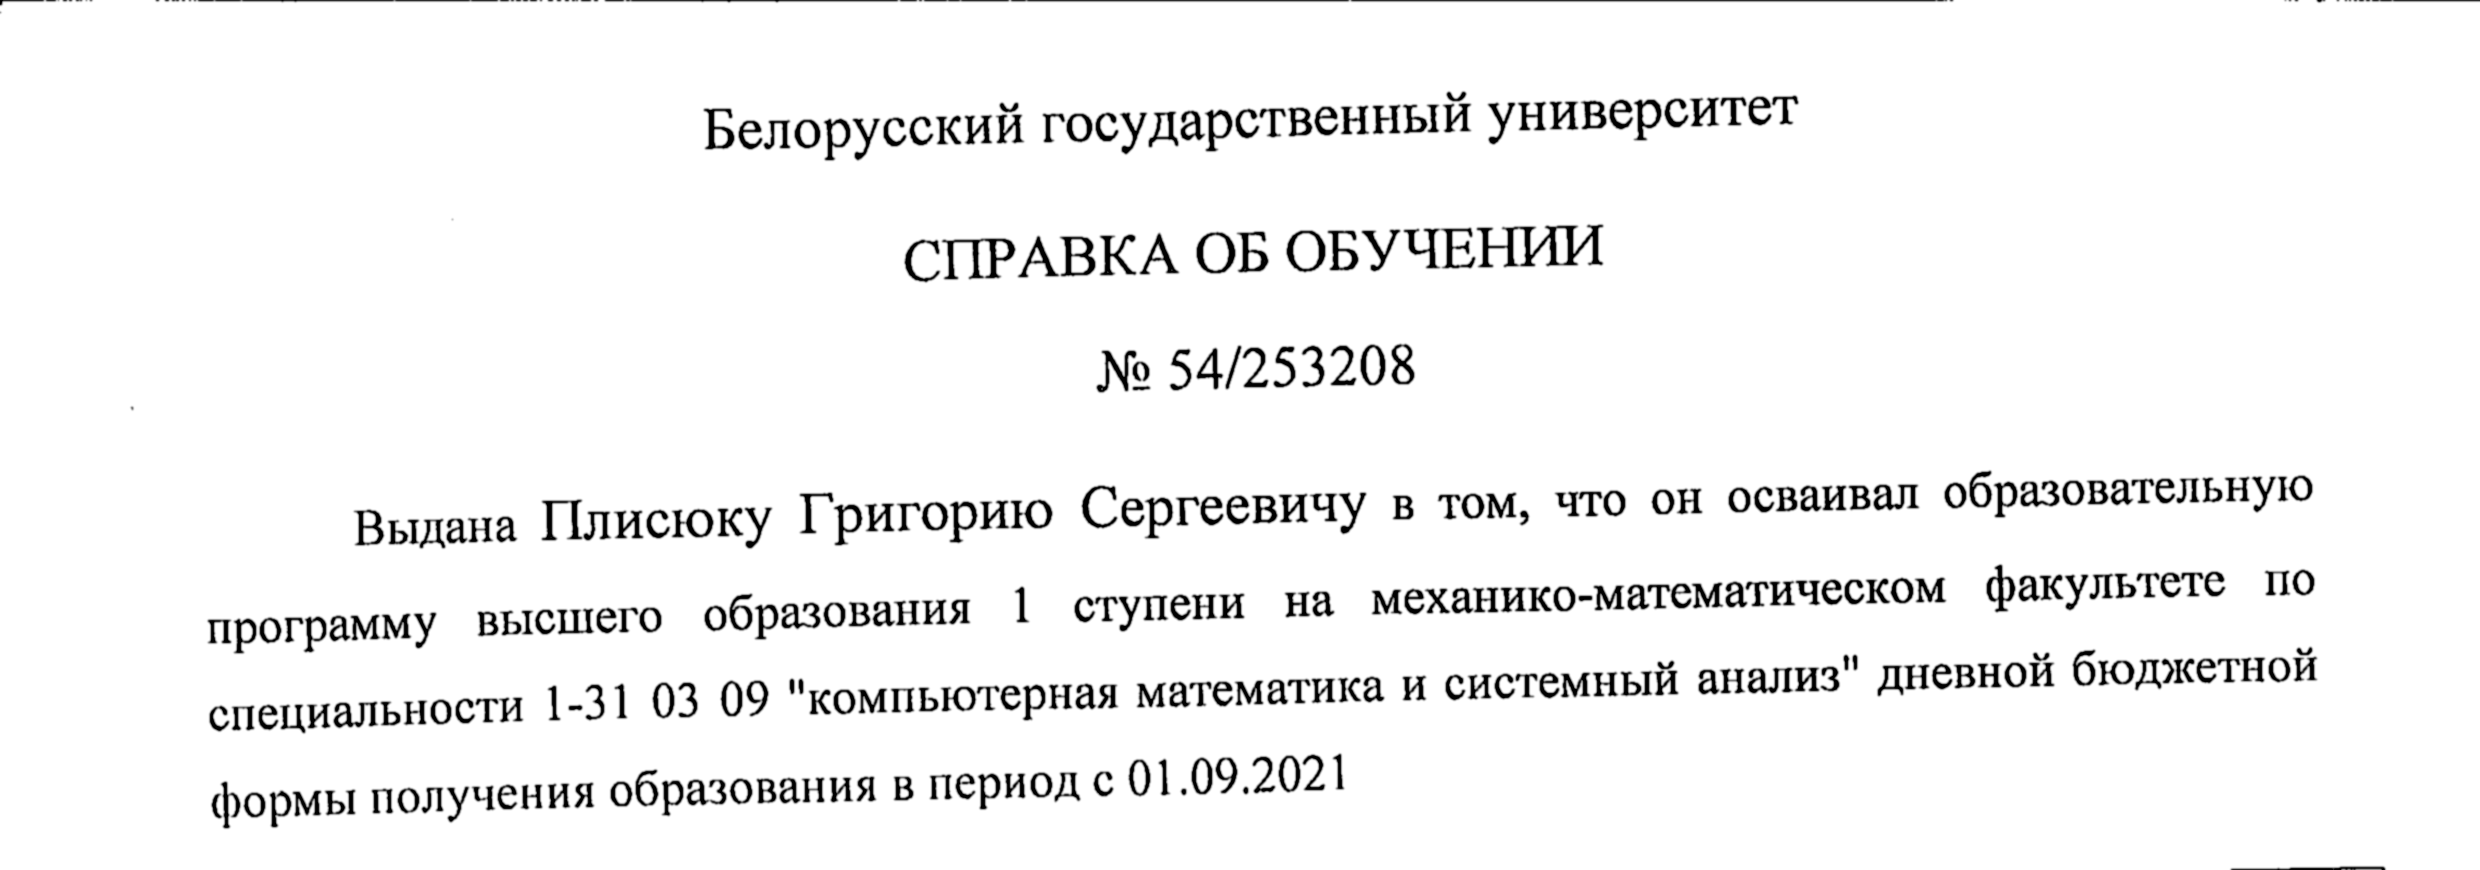

In [4]:
# увеличение констрастности в 1.3 раза
enh = ImageEnhance.Contrast(gauss_image)
gauss_image = enh.enhance(1.3)
gauss_image

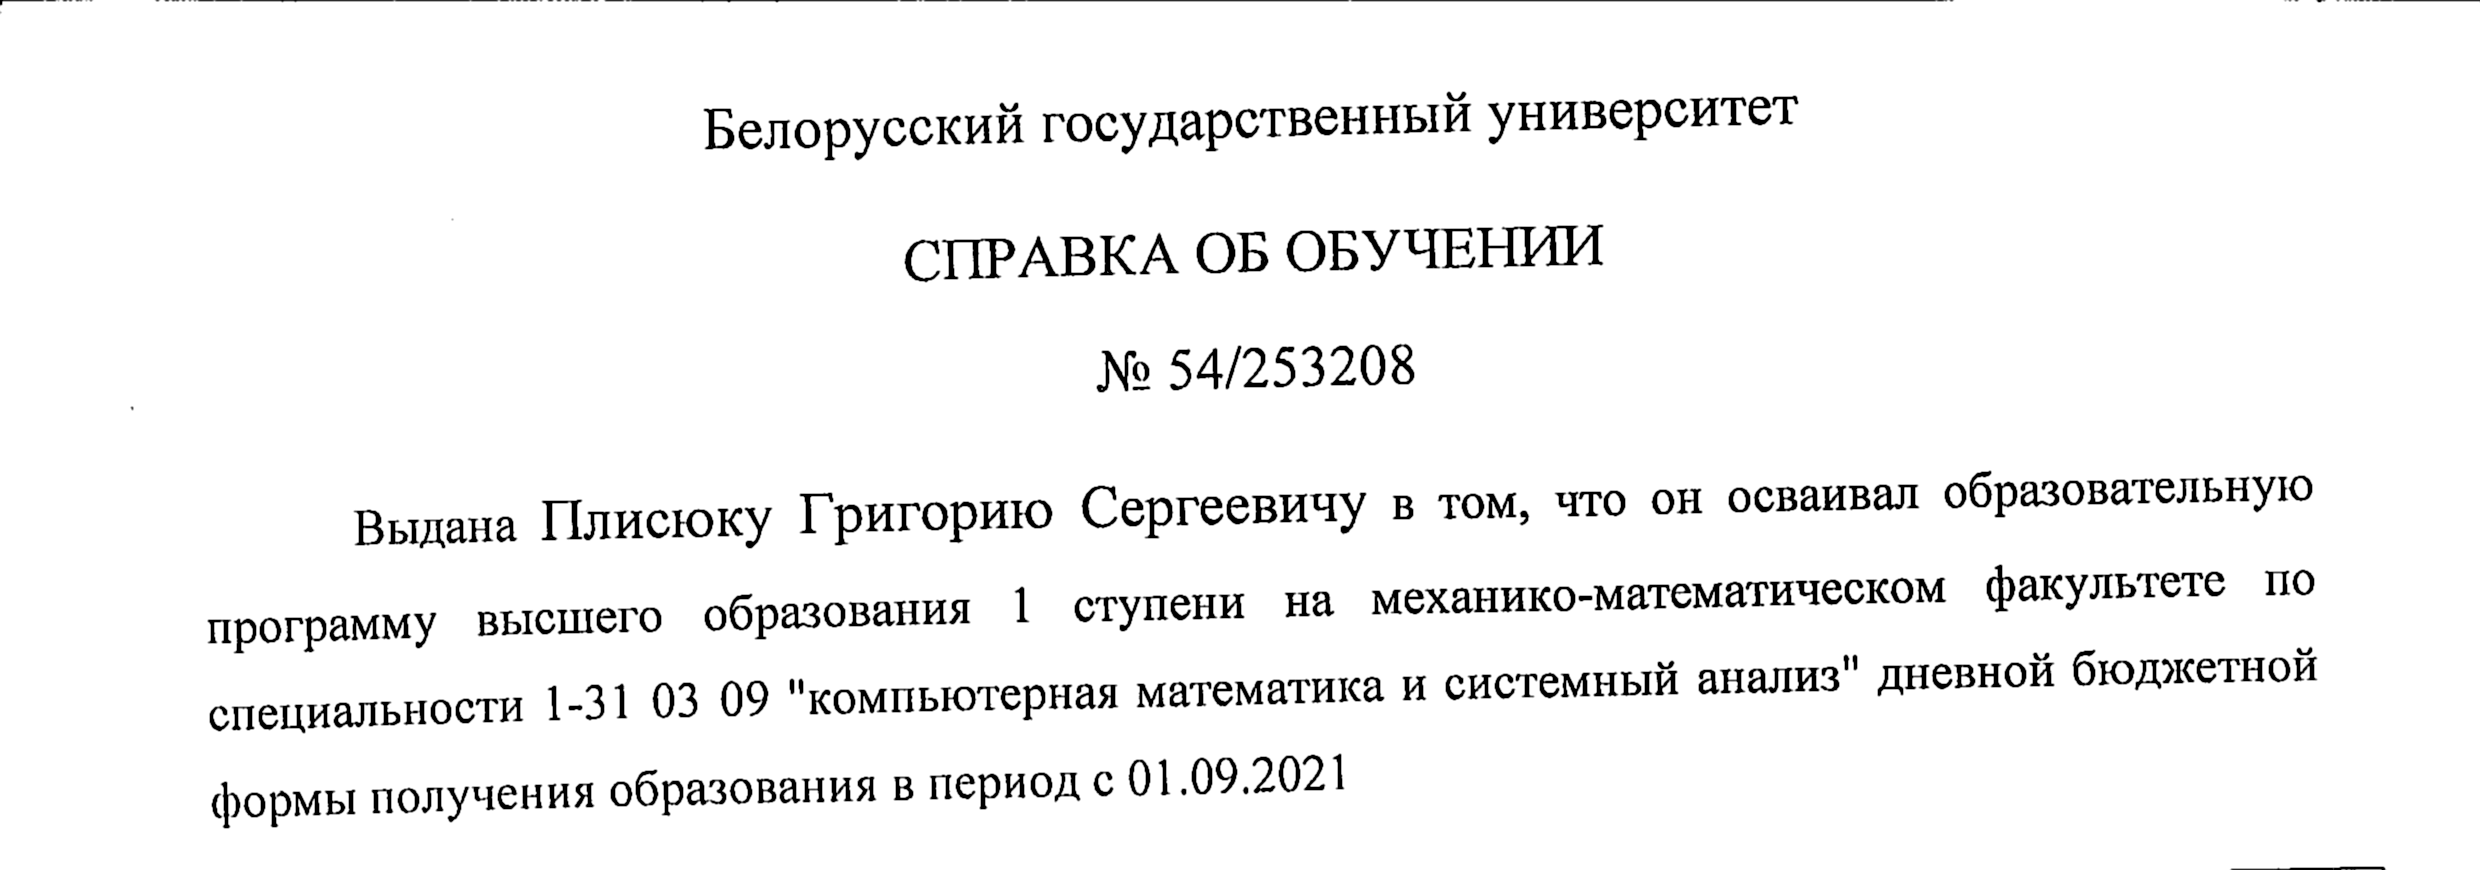

In [5]:
# увеличение резкозти изображения при помощи оператора Лапласа
gauss_image = gauss_image.filter(ImageFilter.SHARPEN)
gauss_image

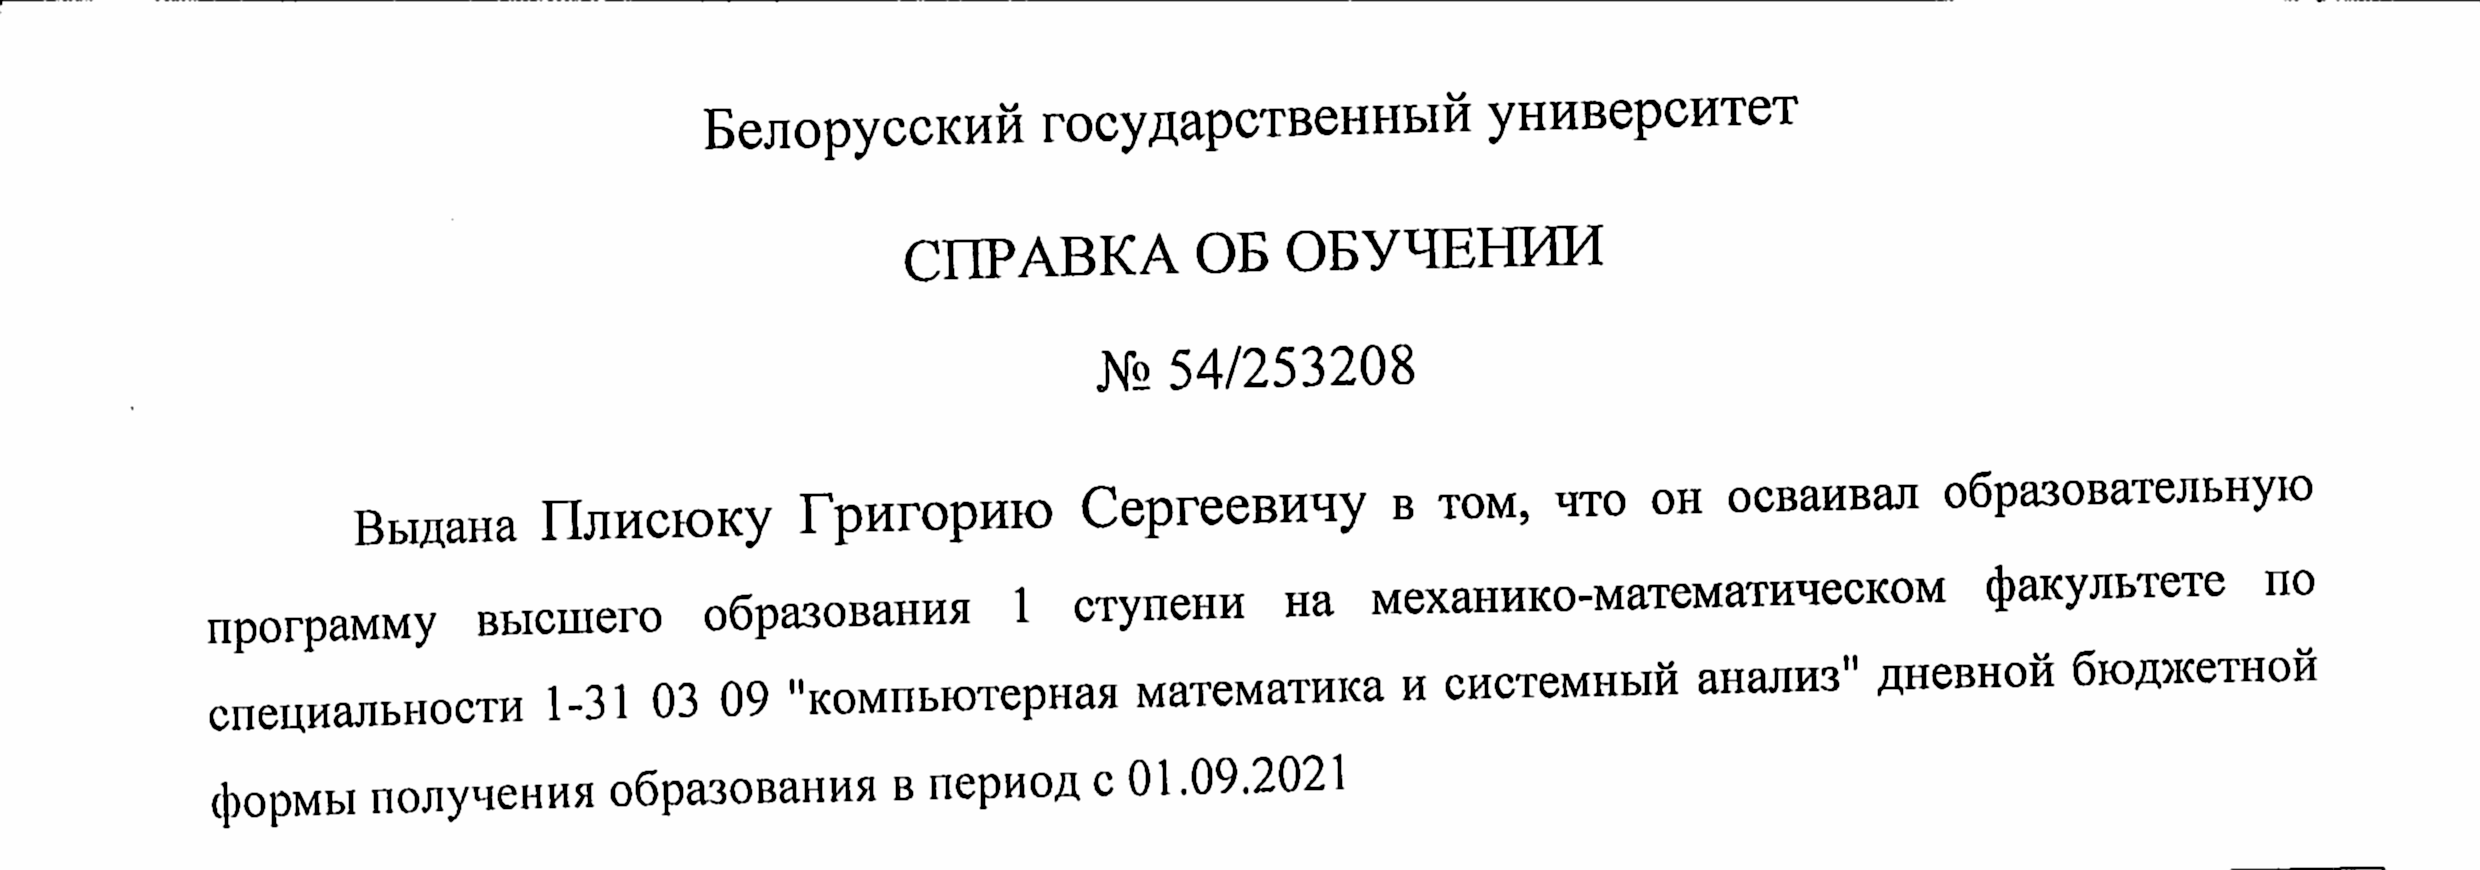

In [6]:
# перевод в градацию серого
r, g, b = gauss_image.split()
r = np.asarray(r.point(lambda x: x*2126//10000))
g = np.asarray(g.point(lambda x: x*7152//10000))
b = np.asarray(b.point(lambda x: x*722//10000))
gray_image_array = r + g + b
Image.fromarray(gray_image_array, mode='L')

### Методы глобальной бинаризации изображений

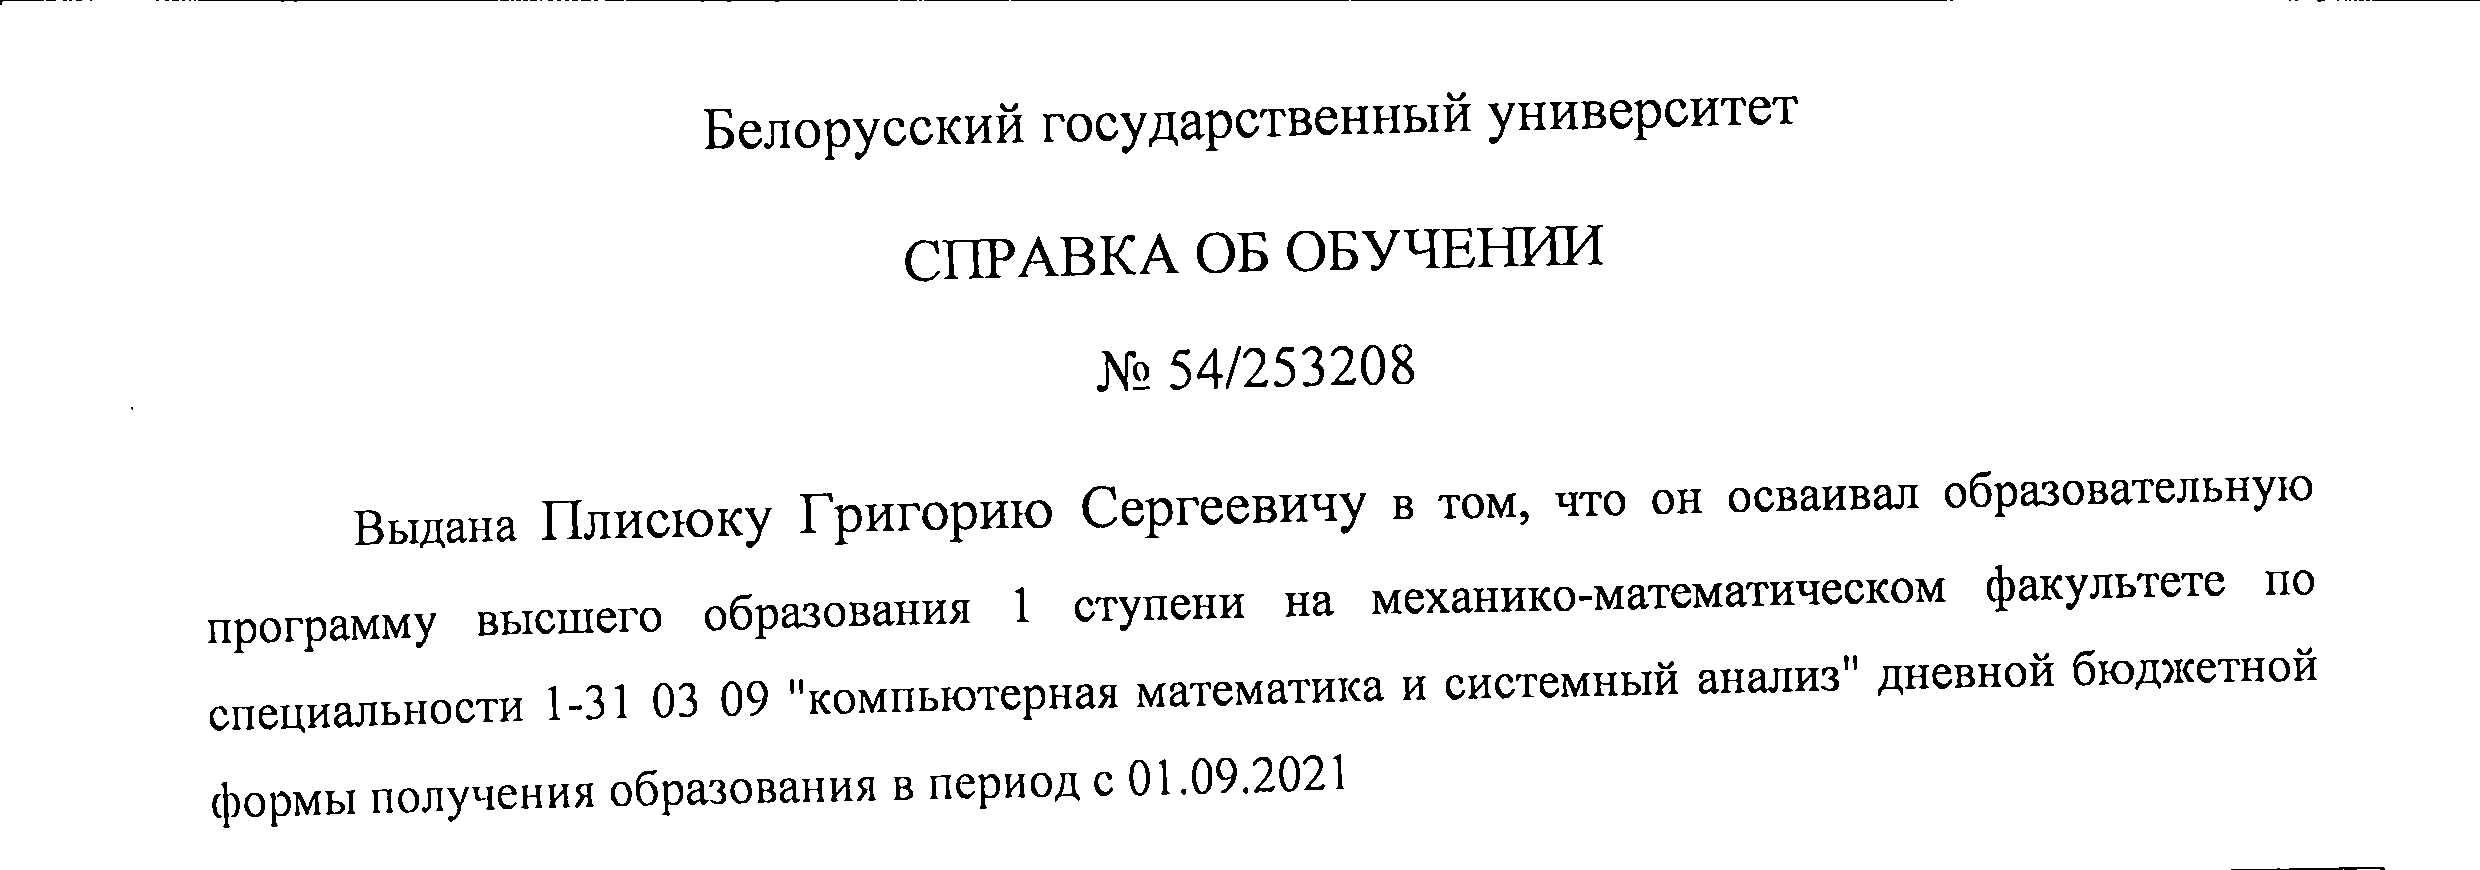

In [7]:
# глобальная бинаризация методом Оцу
thresh = filters.threshold_otsu(gray_image_array)
binary_image_array = gray_image_array > thresh
binary_image = Image.fromarray(binary_image_array)
binary_image

### Алгоритм поворота

In [8]:
# выделение краёв с помощью оператора Лапласа
edges_map = np.asarray(binary_image.filter(ImageFilter.FIND_EDGES))
edges_map

array([[False, False, False, ..., False, False, False],
       [False, False, False, ...,  True,  True,  True],
       [False, False,  True, ..., False, False,  True],
       ...,
       [ True, False, False, ..., False, False,  True],
       [ True, False, False, ..., False, False,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [9]:
# преобразование Хафа для прямых
tested_angles = np.linspace(np.pi/4, 3*np.pi/4, 180, endpoint=False)
hspace, angles, distances = transform.hough_line(edges_map, theta = tested_angles)

# выделение прямых на изображении путём нахождения локальных максимумов
_, line_angles, _ = transform.hough_line_peaks(hspace, angles, distances,
                                               min_distance=1, min_angle=1,
                                               threshold=10,
                                               num_peaks=100)

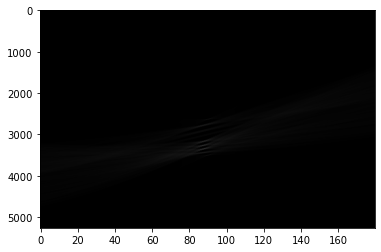

In [10]:
import matplotlib.pyplot as plt
ax = plt.axes()
ax.imshow(hspace, cmap='gray')
ax.set_aspect('auto')

In [11]:
max_index = -1
max_count = -1
angles_count = np.zeros_like(angles)
for line_angle in line_angles:
    for i in range(len(angles)):
        if line_angle == angles[i]:
            angles_count[i] += 1
        if angles_count[i] > max_count:
            max_count = angles_count[i]
            max_index = i
max_count, max_index

(20.0, 87)

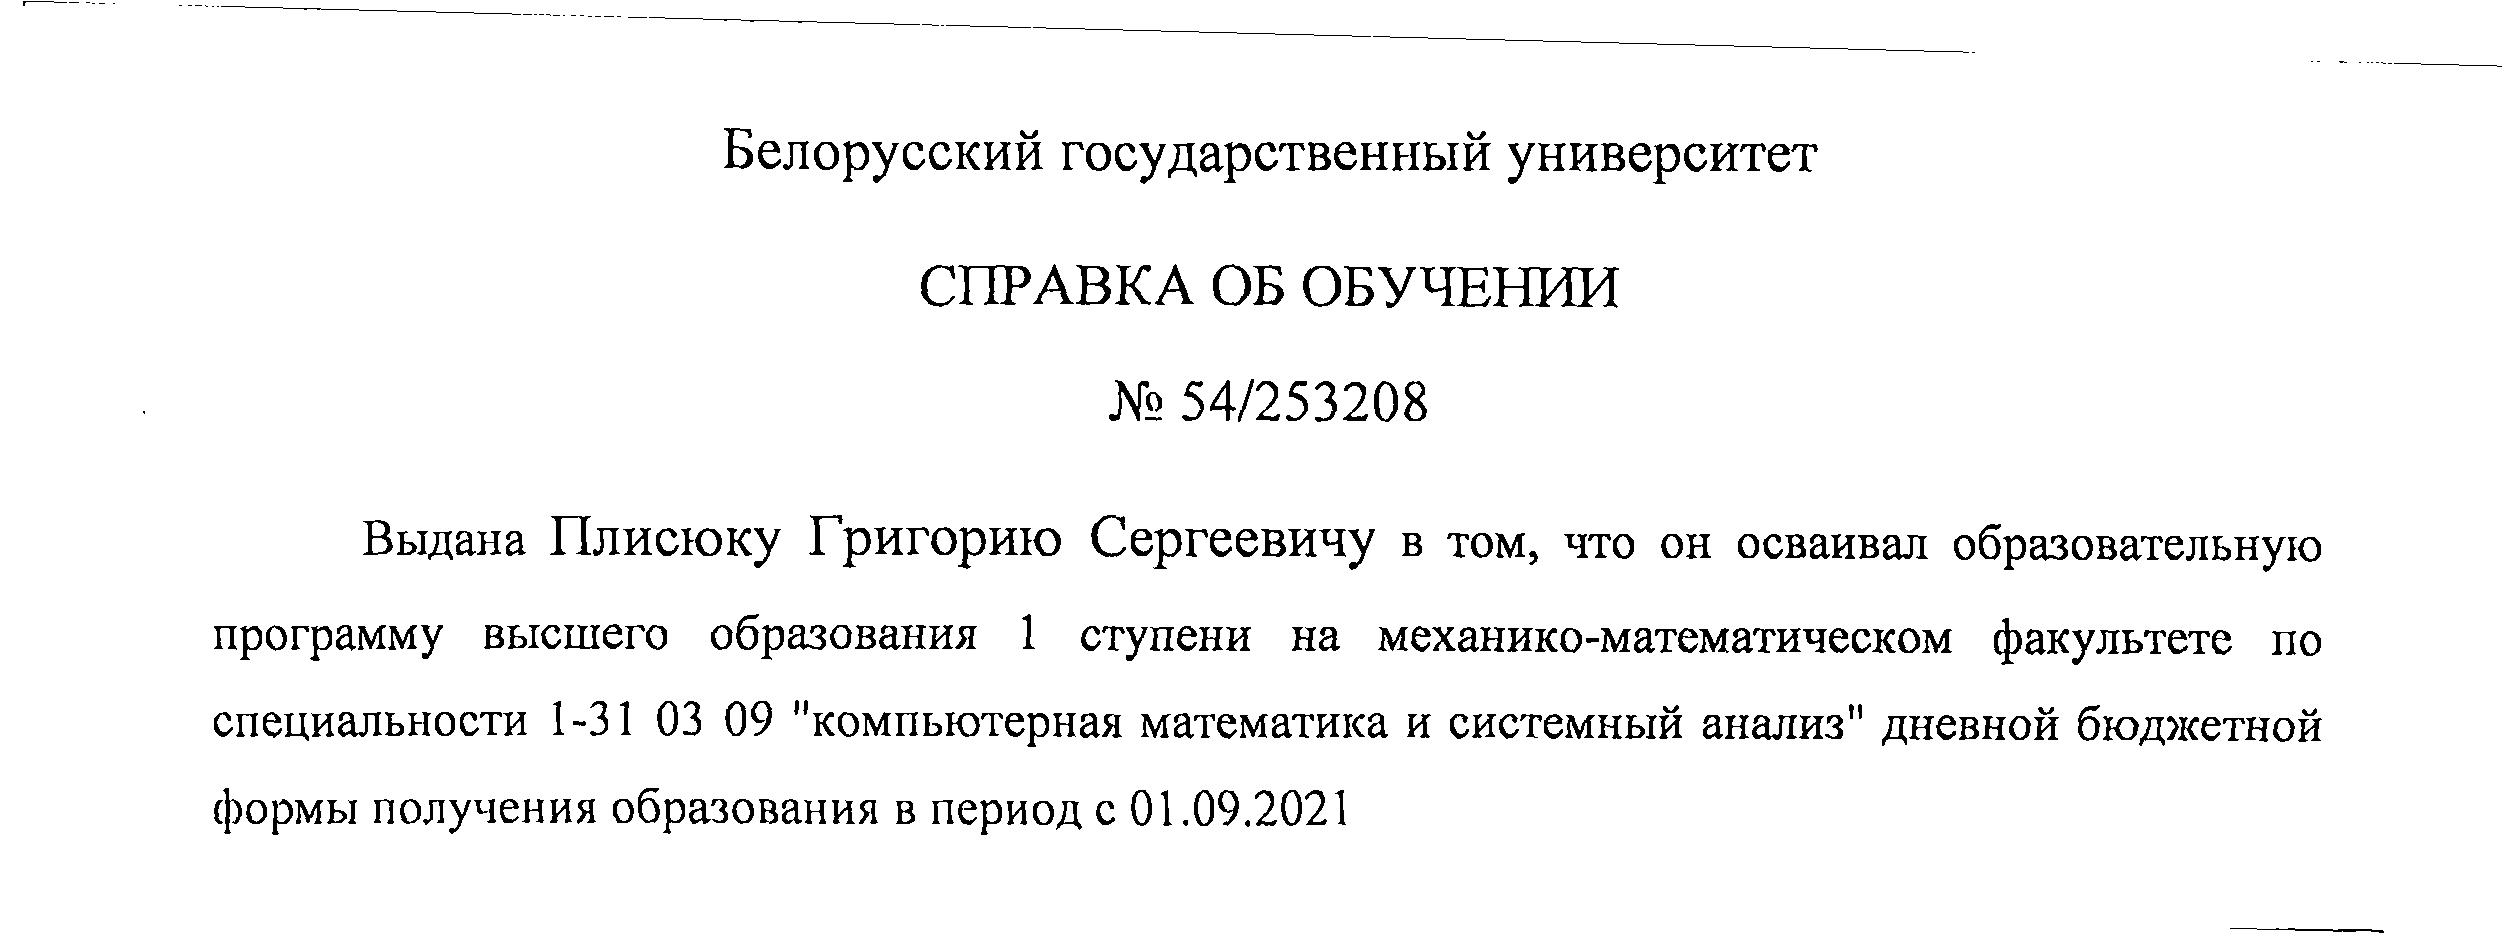

In [12]:
rotated_image = binary_image.rotate(np.rad2deg(angles[max_index])-90, expand=True, fillcolor=255)
rotated_image

### Обрезка

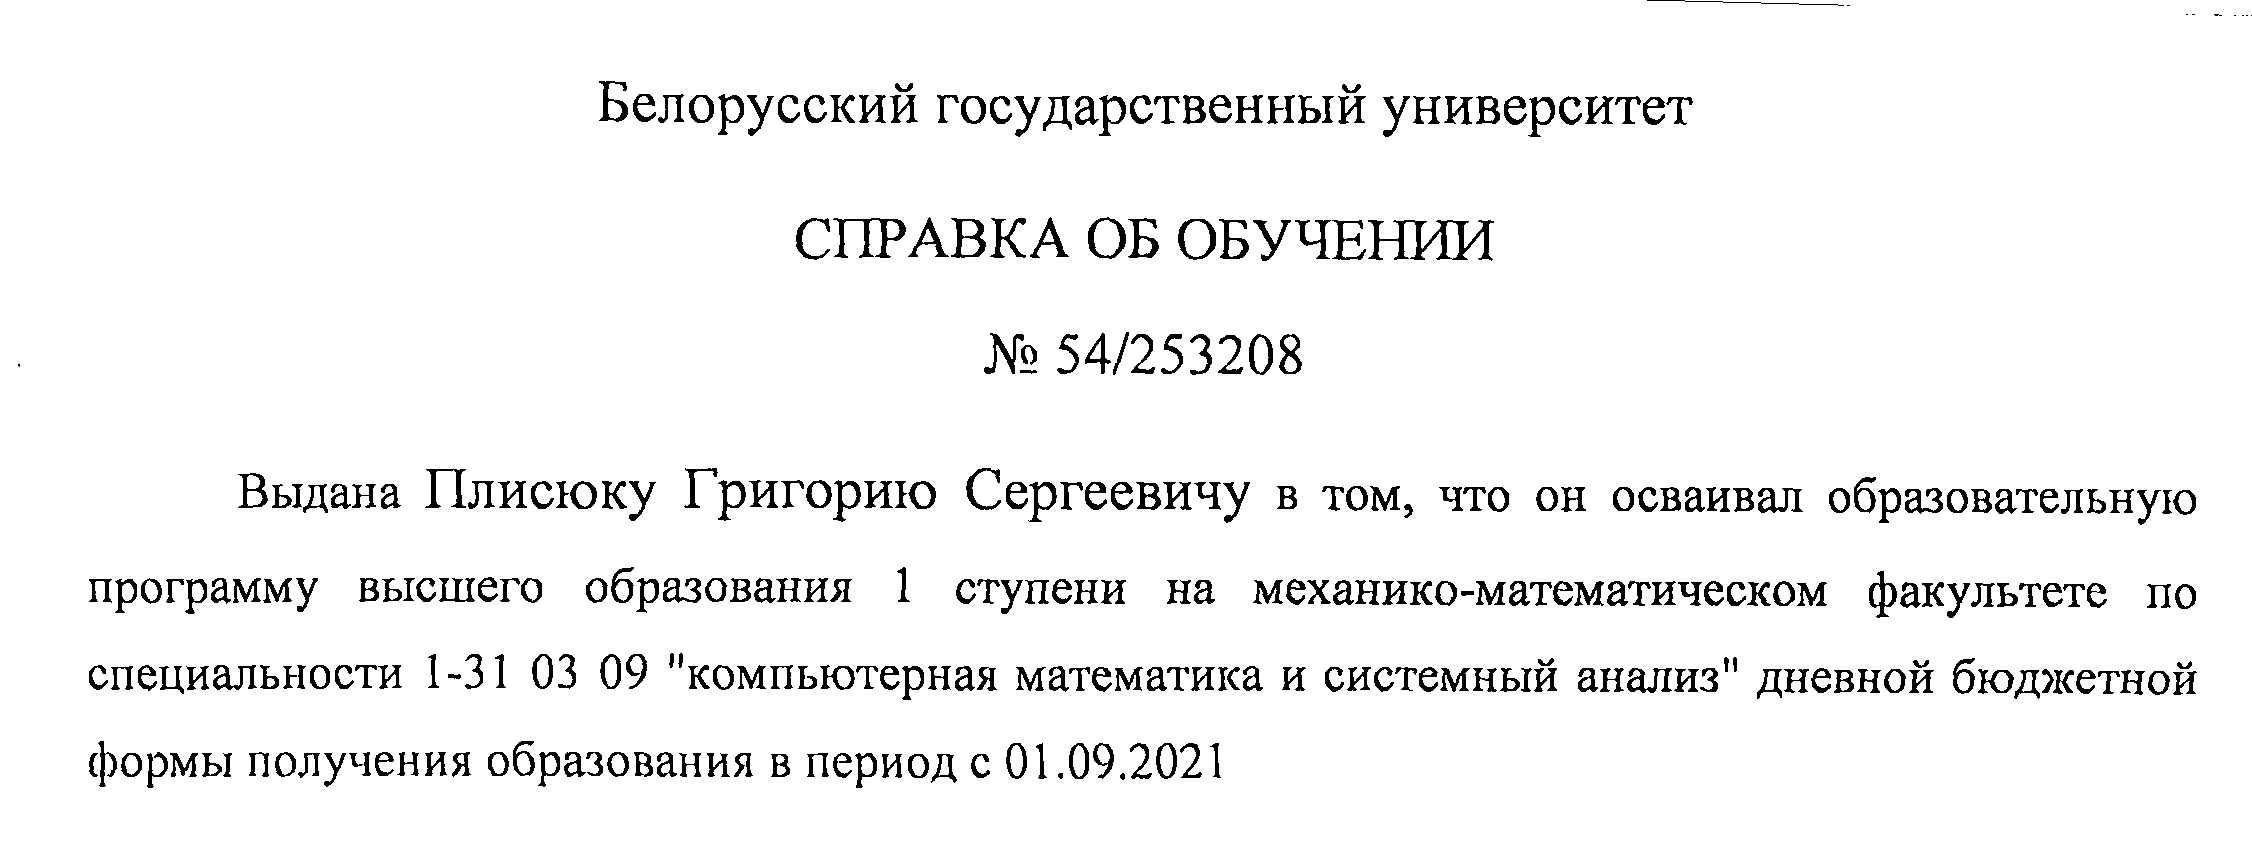

In [13]:
rotated_image = rotated_image.crop((0.05*rotated_image.width, 0.05*rotated_image.height, 
                                    0.95*rotated_image.width, 0.95*rotated_image.height))
rotated_image

### Выделение строк

In [14]:
rotated_image_array = np.asarray(rotated_image)
rotated_image_array = rotated_image_array < 1
width = rotated_image.width
upper = lower = 0
strings = []
is_string = False
for i in range(rotated_image_array.shape[0]):
    suma = np.sum(rotated_image_array[i])
    if is_string:
        if suma == 0:
            is_string = False
            lower = i
            line_height = lower - upper + 1
            strings.append((0, upper-0.1*line_height, width, lower+0.1*line_height))
    else:
        if suma > 0:
            is_string = True
            upper = i
len(strings)

9

In [15]:
strings = [rotated_image.crop(string) for string in strings]

### Выделение символов

In [16]:
all_chars = []
for string in strings:
    string_array = np.asarray(string).transpose()
    string_array = string_array < 1
    height = string.height
    left = right = 0
    chars = []
    is_char = False
    for i in range(string_array.shape[0]):
        suma = np.sum(string_array[i])
        if is_char:
            if suma == 0:
                is_char = False
                right = i
                char_width = right - left + 1
                chars.append((left-0.1*char_width, 0, right+0.1*char_width, height))
        else:
            if suma > 0:
                is_char = True
                left = i
    chars = [string.crop(char) for char in chars]
    all_chars.append(chars)

In [17]:
np.sum(np.array([len(i) for i in all_chars]))

312

In [18]:
init_cwd = os.getcwd()
filename_cut = filename.split('.')[0]
if not(os.access(filename_cut, os.F_OK)):
    os.mkdir(filename_cut)
os.chdir(filename_cut)
for i in range(len(all_chars)):
    for j in range(len(all_chars[i])):
        all_chars[i][j].save('{}_{}_{}.jpg'.format(filename_cut, i, j))
os.chdir(init_cwd)